# Investing in Stocks (Fall 2024)

### Group 6

- Rohit Akole

- Dimitri Alston

- Pranjal Jain

- Sumit Pal

- Nishitha Santhakumar

In this notebook, we study the impact of periodic rebalancing when investing in stocks using Modern Portfolio Theory (MPT), integer programming, and Monte Carlo simulation.

### Import Modules

To begin, we import all relevant Python modules for this project.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

!pip install yahoo_fin
import yahoo_fin.stock_info as si

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.0/201.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.6 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=66bef71ddadb13f29b8f16b4ad0ee8e2c34469ed86dc3529b76d3497147f98c8
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.2.3
    Uninstalling urllib3-2.2.3:
      Successfully uninstalled urllib3-2.2.3
Warning - Certain functionality 
  

In [ ]:
# Import solver
import sys
import os

if 'google.colab' in sys.modules:
   !pip install idaes-pse --pre
   !idaes get-extensions --to ./bin
   os.environ['PATH'] += ':bin'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 17.8 MB/s eta 0:00:00
Getting files...
Done
---------------------------------------------------
IDAES Extensions Build Versions
Solvers:  v3.4.2 20240811 ubuntu2204-x86_64
Library:  v3.4.2 20240811 ubuntu2204-x86_64


In [ ]:
from pylab import *

import shutil
import sys
from pyomo.environ import *
from pyomo.opt import SolverStatus, TerminationCondition

executable = '/content/bin/bonmin'

# 1 Prepare the Data

In this section, we retrieve data for all S&P 500 stocks assigned to our group. The sectors assigned to our group were **Utilities**, **Health Care**, and **Real Estate**.

First, we can get a list of all relevant sectors from Wikipedia and filter them into separate pandas `DataFrame`s.

In [ ]:
# Load the Wikipedia table
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"  # Wikipedia URL
tables = pd.read_html(url)

# The first table contains the S&P 500 list
df = tables[0]

# Filter the table for specific GICS sectors
filtered_df = df[df['GICS Sector'].isin(['Utilities', 'Health Care', 'Real Estate'])]

# Display the filtered table
print(filtered_df)

    Symbol                         Security  GICS Sector  \
2      ABT              Abbott Laboratories  Health Care   
3     ABBV                           AbbVie  Health Care   
7      AES                  AES Corporation    Utilities   
9        A             Agilent Technologies  Health Care   
14     ARE  Alexandria Real Estate Equities  Real Estate   
..     ...                              ...          ...   
491    WST     West Pharmaceutical Services  Health Care   
493     WY                     Weyerhaeuser  Real Estate   
497    XEL                      Xcel Energy    Utilities   
501    ZBH                    Zimmer Biomet  Health Care   
502    ZTS                           Zoetis  Health Care   

                                GICS Sub-Industry    Headquarters Location  \
2                           Health Care Equipment  North Chicago, Illinois   
3                                   Biotechnology  North Chicago, Illinois   
7    Independent Power Producers & Energy Tra

In [ ]:
# Separate the sectors into individual DataFrames
utilities_df = filtered_df[filtered_df['GICS Sector'] == 'Utilities']
healthcare_df = filtered_df[filtered_df['GICS Sector'] == 'Health Care']
realestate_df = filtered_df[filtered_df['GICS Sector'] == 'Real Estate']

# Display information for each DataFrame
print("Utilities Sector Information:")
print(utilities_df.info())
print("\n")

print("Healthcare Sector Information:")
print(healthcare_df.info())
print("\n")

print("Real Estate Sector Information:")
print(realestate_df.info())

Utilities Sector Information:
<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, 7 to 497
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 31 non-null     object
 1   Security               31 non-null     object
 2   GICS Sector            31 non-null     object
 3   GICS Sub-Industry      31 non-null     object
 4   Headquarters Location  31 non-null     object
 5   Date added             31 non-null     object
 6   CIK                    31 non-null     int64 
 7   Founded                31 non-null     object
dtypes: int64(1), object(7)
memory usage: 2.2+ KB
None


Healthcare Sector Information:
<class 'pandas.core.frame.DataFrame'>
Index: 62 entries, 2 to 502
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 62 non-null     object
 1   Security          

Next, we can fetch the daily closing prices for each sector from Jan 1, 2017 to Dec 31, 2022 using Yahoo Finance. If data does not exist at any point within this time period for any of the stocks, then we exclude it from our list.

## 1.1 Utilities Sector DataFrame

In [ ]:
# Extract tickers from the utilities sector
utilities_tickers = utilities_df['Symbol'].tolist()

# Create an empty dictionary to store data
data = {}

# Fetch closing prices for each ticker
for ticker in utilities_tickers:
    try:
        data[ticker] = si.get_data(ticker, start_date='1/1/2017', end_date='12/31/2022', interval='1d')['close']
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Create a DataFrame from the collected data
df_prices = pd.DataFrame(data)

# Remove columns with any NaN values
df_prices.dropna(axis=1, inplace=True)

# Display the resulting DataFrame
df_prices

,AES,LNT,AEE,AEP,AWK,ATO,CNP,CMS,ED,D,...,NRG,PCG,PNW,PPL,PEG,SRE,SO,VST,WEC,XEL
2017-01-03,11.660000,37.930000,52.380001,62.759998,72.250000,74.550003,24.590000,41.529999,73.629997,76.250000,...,12.300000,60.369999,77.320000,34.029999,43.389999,50.564999,49.040001,15.360000,58.490002,40.619999
2017-01-04,11.560000,38.160000,52.439999,62.849998,72.809998,74.970001,24.809999,41.759998,73.559998,76.180000,...,13.030000,60.590000,77.750000,34.099998,43.689999,51.000000,48.990002,16.100000,58.939999,40.799999
2017-01-05,11.410000,38.110001,52.700001,63.189999,72.930000,74.599998,24.809999,41.990002,73.720001,76.279999,...,13.280000,60.540001,78.389999,34.299999,43.759998,50.880001,49.139999,16.190001,59.020000,40.799999
2017-01-06,11.820000,37.799999,53.099998,63.139999,72.839996,74.169998,25.360001,42.150002,73.940002,76.900002,...,13.360000,61.220001,78.489998,34.560001,44.200001,51.459999,49.009998,16.200001,58.779999,40.919998
2017-01-09,11.530000,37.279999,51.990002,62.310001,71.349998,73.209999,24.879999,41.580002,72.760002,75.720001,...,13.470000,60.299999,77.230003,34.220001,43.520000,50.689999,48.529999,15.900000,57.980000,40.299999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,28.680000,55.299999,89.529999,95.690002,153.020004,115.099998,30.690001,63.619999,95.849998,60.790001,...,31.910000,16.059999,77.930000,29.540001,61.080002,78.875000,71.739998,23.870001,95.480003,70.930000
2022-12-27,28.820000,56.029999,90.279999,96.290001,154.279999,115.580002,30.920000,64.309998,96.550003,61.779999,...,32.240002,16.450001,77.709999,29.690001,61.810001,79.419998,72.269997,23.690001,96.010002,71.570000
2022-12-28,28.320000,55.209999,89.379997,95.360001,153.119995,115.070000,30.520000,63.630001,95.970001,61.459999,...,31.860001,16.160000,76.809998,29.440001,61.290001,78.160004,71.650002,23.660000,95.070000,70.570000
2022-12-29,28.809999,56.029999,90.010002,96.010002,154.779999,114.489998,30.480000,64.180000,96.489998,61.639999,...,32.400002,16.340000,77.129997,29.660000,61.830002,77.940002,72.190002,24.070000,95.410004,71.070000


## 1.2 Healthcare Sector DataFrame

In [ ]:
# Extract tickers from the healthcare sector
healthcare_tickers = healthcare_df['Symbol'].tolist()

# Create an empty dictionary to store data
data_healthcare = {}

# Fetch closing prices for each ticker
for ticker in healthcare_tickers:
    try:
        data_healthcare[ticker] = si.get_data(ticker, start_date='1/1/2017', end_date='12/31/2022', interval='1d')['close']
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Create a DataFrame from the collected data
df_healthcare_prices = pd.DataFrame(data_healthcare)

# Remove columns with any NaN values
df_healthcare_prices.dropna(axis=1, inplace=True)

# Display the resulting DataFrame
df_healthcare_prices

Error fetching data for SOLV: {'chart': {'result': None, 'error': {'code': 'Bad Request', 'description': "Data doesn't exist for startDate = 1483228800, endDate = 1672444800"}}}


/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()


,ABT,ABBV,A,ALGN,AMGN,BAX,BDX,TECH,BIIB,BSX,...,TFX,TMO,UNH,UHS,VRTX,VTRS,WAT,WST,ZBH,ZTS
2017-01-03,39.049999,62.410000,46.490002,96.959999,150.729996,44.439999,161.121948,25.652500,291.709991,21.879999,...,158.860001,143.669998,161.449997,106.709999,74.889999,39.110001,136.429993,84.070000,100.320389,53.590000
2017-01-04,39.360001,63.290001,47.099998,97.769997,152.869995,44.750000,160.917068,26.245001,294.049988,22.080000,...,162.850006,145.160004,161.910004,108.809998,77.050003,39.630001,135.490005,85.300003,101.242722,54.110001
2017-01-05,39.700001,63.770000,46.540001,94.820000,152.979996,45.049999,160.780487,25.792500,293.570007,22.049999,...,162.059998,145.380005,162.179993,108.769997,79.059998,39.160000,135.729996,85.029999,101.893204,53.930000
2017-01-06,40.779999,63.790001,47.990002,94.080002,156.779999,45.520000,163.795120,25.930000,295.000000,22.150000,...,165.320007,147.270004,162.410004,108.510002,79.389999,38.500000,139.979996,86.629997,101.902916,54.099998
2017-01-09,40.740002,64.209999,48.139999,94.790001,158.839996,46.169998,164.751221,25.809999,299.019989,22.190001,...,164.970001,147.490005,161.949997,111.540001,82.860001,38.950001,139.179993,86.839996,103.883492,53.950001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,108.180000,163.100006,149.229996,203.669998,263.920013,50.169998,254.470001,82.730003,279.160004,46.060001,...,248.809998,540.679993,531.309998,140.759995,289.690002,11.010000,346.660004,235.130005,126.690002,145.759995
2022-12-27,108.570000,162.990005,149.550003,204.589996,263.390015,50.840000,255.300003,82.209999,274.769989,46.240002,...,248.869995,545.440002,531.989990,141.259995,287.320007,11.040000,346.529999,236.729996,127.279999,145.300003
2022-12-28,107.830002,162.229996,148.089996,201.580002,261.420013,50.360001,253.119995,80.690002,274.040009,45.779999,...,247.550003,543.409973,528.450012,139.369995,285.760010,10.920000,340.709991,231.240005,125.989998,143.830002
2022-12-29,110.309998,162.559998,151.089996,212.139999,263.160004,51.119999,256.899994,84.470001,276.000000,46.349998,...,251.350006,557.010010,529.880005,140.789993,289.079987,11.130000,345.880005,238.979996,127.830002,148.149994


## 1.3 Real Estate Sector DataFrame

In [ ]:
# Extract tickers from the realestate sector
realestate_tickers = realestate_df['Symbol'].tolist()

# Create an empty dictionary to store data
data_realestate = {}

# Fetch closing prices for each ticker
for ticker in realestate_tickers:
    try:
        data_realestate[ticker] = si.get_data(ticker, start_date='1/1/2017', end_date='12/31/2022', interval='1d')['close']
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Create a DataFrame from the collected data
df_realestate_prices = pd.DataFrame(data_realestate)

# Remove columns with any NaN values
df_realestate_prices.dropna(axis=1, inplace=True)

# Display the resulting DataFrame
df_realestate_prices

/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()
/usr/local/lib/python3.10/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()


,ARE,AMT,AVB,BXP,CPT,CBRE,CSGP,CCI,DLR,EQIX,...,PLD,PSA,O,REG,SBAC,SPG,UDR,VTR,WELL,WY
2017-01-03,110.580002,106.150002,176.619995,127.180000,84.059998,31.570000,18.615000,86.800003,99.360001,358.720001,...,52.799999,223.520004,55.707363,68.889999,105.529999,182.619995,35.950001,62.130001,66.169998,30.360001
2017-01-04,113.379997,106.339996,177.350006,131.220001,85.279999,32.080002,19.080000,87.320000,102.510002,365.910004,...,53.740002,225.160004,56.540699,69.989998,105.680000,184.080002,36.310001,62.610001,66.680000,30.629999
2017-01-05,112.970001,105.970001,178.429993,131.850006,85.199997,31.809999,19.146999,87.239998,105.239998,369.750000,...,53.759998,227.559998,58.062016,70.150002,104.279999,184.399994,36.430000,63.169998,68.169998,30.950001
2017-01-06,112.209999,105.269997,180.000000,131.550003,84.800003,31.200001,19.177000,85.500000,104.040001,370.489990,...,54.110001,228.350006,57.984497,70.300003,103.519997,186.830002,36.430000,63.049999,68.449997,30.850000
2017-01-09,111.050003,105.019997,177.220001,130.240005,84.010002,31.129999,19.243000,85.730003,102.800003,373.190002,...,53.700001,226.789993,57.558140,69.330002,102.989998,185.910004,36.049999,63.450001,68.400002,30.969999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,147.240005,212.449997,163.029999,68.400002,111.309998,76.669998,76.889999,136.979996,100.870003,657.679993,...,113.620003,283.209991,64.410004,62.639999,282.510010,117.910004,38.750000,45.490002,65.070000,31.490000
2022-12-27,146.449997,210.899994,162.800003,68.900002,111.510002,76.489998,76.750000,136.929993,100.349998,654.580017,...,113.290001,283.040009,64.110001,62.610001,282.500000,118.099998,38.520000,45.820000,65.940002,31.469999
2022-12-28,143.449997,210.100006,161.080002,66.339996,109.860001,75.410004,76.050003,134.860001,99.400002,652.539978,...,110.449997,277.989990,63.230000,61.650002,278.700012,115.059998,37.939999,44.810001,64.839996,30.629999
2022-12-29,145.199997,215.740005,162.649994,67.540001,112.940002,77.550003,77.669998,138.410004,101.300003,665.369995,...,113.970001,282.579987,64.029999,62.639999,284.890015,117.320000,38.910000,45.560001,65.830002,31.320000


## 1.4 Top 3 Stocks per Sector

Once we have our prices, we can determine the top 3 stocks from each sector that achieve the highest returns based the percent change for each one.

In [ ]:
# Calculate percentage change for each ticker
def calculate_percentage_change(df):
    df_pct_change = df.pct_change()
    return df_pct_change

# Calculate mean percentage change for each ticker
def calculate_mean_percentage_change(df_pct_change):
    df_mean_pct_change = df_pct_change.mean()
    return df_mean_pct_change

# Function to get top N tickers from each sector
def get_top_n_tickers(df_prices, n=3):
    df_pct_change = calculate_percentage_change(df_prices)
    df_mean_pct_change = calculate_mean_percentage_change(df_pct_change)

    # Sort by mean percentage change in descending order
    df_mean_pct_change_sorted = df_mean_pct_change.sort_values(ascending=False)

    # Get the top N tickers
    top_n_tickers = df_mean_pct_change_sorted.head(n).index.tolist()
    return top_n_tickers

# Get top 3 tickers for each sector
top_utilities_tickers = get_top_n_tickers(df_prices)
top_healthcare_tickers = get_top_n_tickers(df_healthcare_prices)
top_realestate_tickers = get_top_n_tickers(df_realestate_prices)

# Create a list of dictionaries to store the top tickers and their mean percentage change
top_tickers_data = []
for sector, tickers, df in [('Utilities', top_utilities_tickers, df_prices),
                            ('Health Care', top_healthcare_tickers, df_healthcare_prices),
                            ('Real Estate', top_realestate_tickers, df_realestate_prices)]:

    for ticker in tickers:
        pct_change = calculate_percentage_change(df[[ticker]])
        mean_pct_change = calculate_mean_percentage_change(pct_change)
        top_tickers_data.append({'Sector': sector, 'Ticker': ticker, 'Mean Percentage Change': mean_pct_change.iloc[0]})

# Create the DataFrame
top_tickers_df = pd.DataFrame(top_tickers_data)
top_tickers_df

,Sector,Ticker,Mean Percentage Change
0,Utilities,NRG,0.000892
1,Utilities,AES,0.000833
2,Utilities,NEE,0.000812
3,Health Care,DXCM,0.001864
4,Health Care,PODD,0.001740
5,Health Care,MOH,0.001507
6,Real Estate,CSGP,0.001158
7,Real Estate,CBRE,0.000832
8,Real Estate,SBAC,0.000798


Now, we can create a `DataFrame` for the top 3 stocks in each sector.

In [ ]:
# Combine top tickers from all sectors
top_9_tickers = top_utilities_tickers + top_healthcare_tickers + top_realestate_tickers

# Create an empty dictionary to store data for the top 9 tickers
data_top_9 = {}

# Fetch closing prices for the top 9 tickers
for ticker in top_9_tickers:
    try:
        data_top_9[ticker] = si.get_data(ticker, start_date='1/1/2017', end_date='12/31/2022', interval='1d')['close']
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Create a DataFrame from the collected data for top 9 tickers
df_top_9_prices = pd.DataFrame(data_top_9)

# Remove columns with any NaN values
df_top_9_prices.dropna(axis=1, inplace=True)

# Display the resulting DataFrame
df_top_9_prices

,NRG,AES,NEE,DXCM,PODD,MOH,CSGP,CBRE,SBAC
2017-01-03,12.300000,11.660000,29.680000,14.562500,37.349998,53.590000,18.615000,31.570000,105.529999
2017-01-04,13.030000,11.560000,29.767500,15.180000,37.599998,55.520000,19.080000,32.080002,105.680000
2017-01-05,13.280000,11.410000,29.750000,15.665000,36.980000,56.470001,19.146999,31.809999,104.279999
2017-01-06,13.360000,11.820000,29.662500,15.807500,37.900002,57.090000,19.177000,31.200001,103.519997
2017-01-09,13.470000,11.530000,29.587500,15.622500,38.290001,56.770000,19.243000,31.129999,102.989998
...,...,...,...,...,...,...,...,...,...
2022-12-23,31.910000,28.680000,84.169998,111.440002,292.089996,335.079987,76.889999,76.669998,282.510010
2022-12-27,32.240002,28.820000,84.000000,109.879997,292.049988,334.369995,76.750000,76.489998,282.500000
2022-12-28,31.860001,28.320000,83.160004,109.769997,290.040009,332.420013,76.050003,75.410004,278.700012
2022-12-29,32.400002,28.809999,84.080002,112.070000,295.040009,333.269989,77.669998,77.550003,284.890015


In [ ]:
# Create a DataFrame to store the values
return_data = pd.DataFrame()

# For loop to store all the values for given dates
for i in top_9_tickers:
    return_data[i] = si.get_data(i, start_date='1/1/2017', end_date='12/31/2022', interval='1d')['close'].pct_change()
return_data.dropna(inplace=True)
return_data.head()

,NRG,AES,NEE,DXCM,PODD,MOH,CSGP,CBRE,SBAC
2017-01-04,0.059350,-0.008576,0.002948,0.042403,0.006693,0.036014,0.024980,0.016155,0.001421
2017-01-05,0.019186,-0.012976,-0.000588,0.031950,-0.016489,0.017111,0.003512,-0.008417,-0.013248
2017-01-06,0.006024,0.035933,-0.002941,0.009097,0.024878,0.010979,0.001567,-0.019176,-0.007288
2017-01-09,0.008234,-0.024535,-0.002528,-0.011703,0.010290,-0.005605,0.003442,-0.002244,-0.005120
2017-01-10,0.011136,-0.017346,0.001943,0.072812,0.075999,0.021138,0.009198,-0.005461,-0.003787


## 1.5 Plots

We present a time-series visualization of each selected stock over the given time period based on the daily return ratio for each stock.

### 1.5.1 Return Ratio per Sector

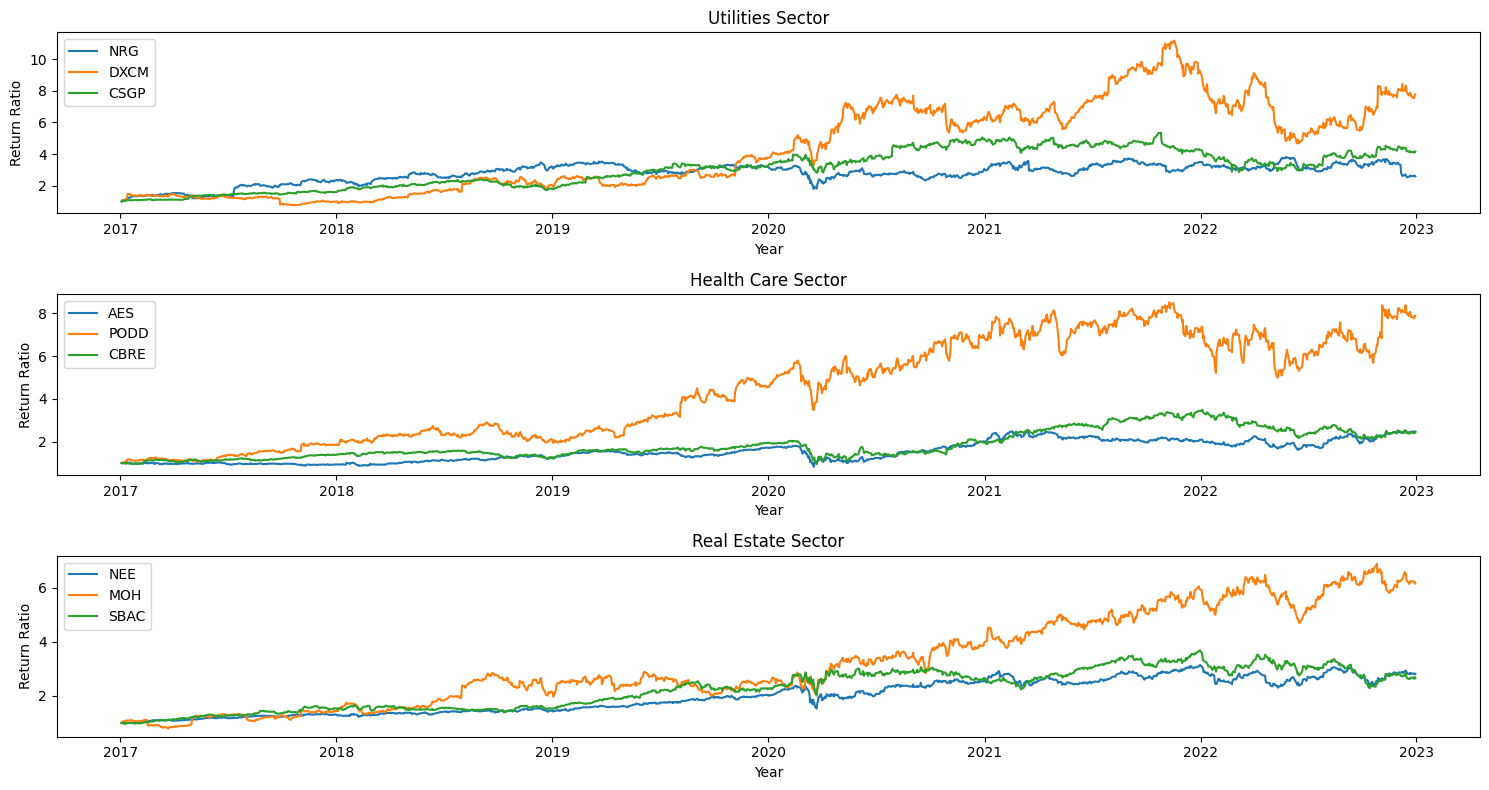

In [ ]:
# Create a plot
plt.figure(figsize=(15, 8))

# Loop through each sector and plot each ticker on the appropriate subplot
sectors = top_tickers_df['Sector'].unique()
for sector in sectors:
    sector_tickers = top_tickers_df[top_tickers_df['Sector'] == sector]['Ticker'].tolist()
    i = 0  # Subplot counter
    for ticker in sector_tickers:
        if ticker in df_top_9_prices.columns:
          i += 1
          returns = (df_top_9_prices[ticker] / df_top_9_prices[ticker].iloc[0])
          plt.subplot(3, 1, i)
          plt.plot(returns.index, returns.values, label=ticker)

# Plot for the utilities sector
plt.subplot(3, 1, 1)
plt.title('Utilities Sector')
plt.xlabel('Year')
plt.ylabel('Return Ratio')
plt.legend()

# Plot for the health care sector
plt.subplot(3, 1, 2)
plt.title('Health Care Sector')
plt.xlabel('Year')
plt.ylabel('Return Ratio')
plt.legend()

# Plot for the real estate sector
plt.subplot(3, 1, 3)
plt.title('Real Estate Sector')
plt.xlabel('Year')
plt.ylabel('Return Ratio')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# 2 Modern Portfolio Theory

In this section, we develop and solve an optimizaton model to determine the optimal portfolio allocations using our top 9 stocks from the previous section.

## 2.1 Optimization Model

Using Pyomo, we construct our model and solve for a range of risk levels.

We first need to define our problem.

### 2.1.1 Objective Function

Our goal is to maximize the total returns of the portfolio.

$\max \sum_{i=1}^{9} r_{i} x_{i}$

$r_{i}$ represents the average returns of stock $i$ and $x_{i}$ represents the allocation of stock $i$, where $0 \leq x_{i} \leq 1 \;\;\; \forall i \in [1,9]$.

To create our model, we need to start by defining our variables.

The first 9 variables represent the allocation of the stocks in our portfolio.

The following 9 are binary variables to enable or disable the use of a stock.

We can define our binary variables as $y_{i}$, where $y_{i} \in \{ 0, 1 \} \;\;\; \forall i \in [1,9]$.

In [ ]:
m = ConcreteModel()

# Defining variables
# each one is a stock (NRG, AES, NEE, DXCM,	PODD, MOH, CSGP,	CBRE,	SBAC)
# Utility Sector
m.NRG = Var(within=NonNegativeReals, bounds=(0,1))
m.AES = Var(within=NonNegativeReals, bounds=(0,1))
m.NEE = Var(within=NonNegativeReals, bounds=(0,1))
# Healthcare Sector
m.DXCM = Var(within=NonNegativeReals, bounds=(0,1))
m.PODD = Var(within=NonNegativeReals, bounds=(0,1))
m.MOH = Var(within=NonNegativeReals, bounds=(0,1))
# Real Estate Sector
m.CSGP = Var(within=NonNegativeReals, bounds=(0,1))
m.CBRE = Var(within=NonNegativeReals, bounds=(0,1))
m.SBAC = Var(within=NonNegativeReals, bounds=(0,1))

# Binary Activation Variables per Stock
# Utility Sector
m.activate_NRG = Var(within=Binary)
m.activate_AES = Var(within=Binary)
m.activate_NEE = Var(within=Binary)
# Healthcare Sector
m.activate_DXCM = Var(within=Binary)
m.activate_PODD = Var(within=Binary)
m.activate_MOH = Var(within=Binary)
# Real Estate Sector
m.activate_CSGP = Var(within=Binary)
m.activate_CBRE = Var(within=Binary)
m.activate_SBAC = Var(within=Binary)

We need to determine the average value of each stock for our objective function.

In [ ]:
# Objective function coefficients
df_return = return_data.mean()
print('Average Return')
df_return

Average Return


,0
NRG,0.000892
AES,0.000833
NEE,0.000812
DXCM,0.001864
PODD,0.001740
MOH,0.001507
CSGP,0.001158
CBRE,0.000832
SBAC,0.000798


Now, we can declare our objective.

In [ ]:
# Declare objective (maximize returns)
m.objective = Objective(expr =
                        m.NRG*df_return.iloc[0] +
                        m.AES*df_return.iloc[1] +
                        m.NEE*df_return.iloc[2] +
                        m.DXCM*df_return.iloc[3] +
                        m.PODD*df_return.iloc[4] +
                        m.MOH*df_return.iloc[5] +
                        m.CSGP*df_return.iloc[6] +
                        m.CBRE*df_return.iloc[7] +
                        m.SBAC*df_return.iloc[8],
                        sense=maximize)

### 2.1.2 Constraints

Next, we define and declare our constraints.

The first constraint represents the total allocation, which must equal 1.

$\sum_{i=1}^{9} x_{i} = 1$

In [ ]:
# 1. Sum of all proportions = 1
m.sum_proportions = Constraint(expr = m.NRG + m.AES + m.NEE + m.DXCM + m.PODD + m.MOH + m.CSGP + m.CBRE + m.SBAC == 1)

The second constraint represents the total (or maximum allowed) risk, $R$, of the allocation based on the covariance, $c_{i,j}$ of each stock $i$ in relation to another $j$.

$\sum_{i=1}^{9} \sum_{j=1}^{9} c_{i,j} x_{i} x_{j} <= R$

We need to calculate the covariance matrix to determine the relationship between each stock for use in our risk constraint.

In [ ]:
# Creating covariance table on stock return DataFrame
df_cov = return_data.cov()
print('\t\t\t\t\tCovariance Matrix')
df_cov

					Covariance Matrix


,NRG,AES,NEE,DXCM,PODD,MOH,CSGP,CBRE,SBAC
NRG,0.000529,0.000247,0.000149,0.000183,0.000172,0.000156,0.000134,0.000219,0.000135
AES,0.000247,0.000465,0.000175,0.000175,0.000166,0.000136,0.000163,0.000233,0.000126
NEE,0.000149,0.000175,0.000251,0.000127,0.000129,0.000114,0.000124,0.000137,0.000155
DXCM,0.000183,0.000175,0.000127,0.001013,0.000459,0.000231,0.000260,0.000198,0.000151
PODD,0.000172,0.000166,0.000129,0.000459,0.000754,0.000193,0.000228,0.000198,0.000152
MOH,0.000156,0.000136,0.000114,0.000231,0.000193,0.000606,0.000164,0.000164,0.000141
CSGP,0.000134,0.000163,0.000124,0.000260,0.000228,0.000164,0.000432,0.000212,0.000143
CBRE,0.000219,0.000233,0.000137,0.000198,0.000198,0.000164,0.000212,0.000482,0.000143
SBAC,0.000135,0.000126,0.000155,0.000151,0.000152,0.000141,0.000143,0.000143,0.000303


In [ ]:
# 2. Set maximum risk
m.total_risk = Constraint(expr = m.NRG + m.AES + m.NEE + m.DXCM + m.PODD + m.MOH + m.CSGP + m.CBRE + m.SBAC >= 0.0)

The next set of constraints enforces that at least 1 stock per sector is chosen, using the binary variables defined previously.

$y_{1} + y_{2} + y_{3} \geq 1$

$y_{4} + y_{5} + y_{6} \geq 1$

$y_{7} + y_{8} + y_{9} \geq 1$

In [ ]:
# 3. Select at least 1 stock per sector
# Utility Sector
m.utility_selection = Constraint(expr = m.activate_NRG + m.activate_AES + m.activate_NEE >= 1)
# Healthcare Sector
m.healthcare_selection = Constraint(expr = m.activate_DXCM + m.activate_PODD + m.activate_MOH >= 1)
# Real Estate Sector
m.realestate_selection = Constraint(expr = m.activate_CSGP + m.activate_CBRE + m.activate_SBAC >= 1)

The next set of constraints forces diversity in the portfolio by setting the minimum allocation of a selected stock to 2%.

$x_{i} \geq 0.02 y_{i} \;\;\; \forall i \in [1,9]$

In [ ]:
# 4. For each selected stock, the minimum allocation must be at least 2%
# Utility Sector
m.min_allocation_NRG = Constraint(expr = m.NRG >= 0.02 * m.activate_NRG)
m.min_allocation_AES = Constraint(expr = m.AES >= 0.02 * m.activate_AES)
m.min_allocation_NEE = Constraint(expr = m.NEE >= 0.02 * m.activate_NEE)
# Healthcare Sector
m.min_allocation_DXCM = Constraint(expr = m.DXCM >= 0.02 * m.activate_DXCM)
m.min_allocation_PODD = Constraint(expr = m.PODD >= 0.02 * m.activate_PODD)
m.min_allocation_MOH = Constraint(expr = m.MOH >= 0.02 * m.activate_MOH)
# Real Estate Sector
m.min_allocation_CSGP = Constraint(expr = m.CSGP >= 0.02 * m.activate_CSGP)
m.min_allocation_CBRE = Constraint(expr = m.CBRE >= 0.02 * m.activate_CBRE)
m.min_allocation_SBAC = Constraint(expr = m.SBAC >= 0.02 * m.activate_SBAC)

The next set of constraints forces the maximum allocation of each selected stock to be 100%.

$x_{i} \leq y_{i} \;\;\; \forall i \in [1,9]$

In [ ]:
# 5. For each selected stock, the maximum allocation must be at most 100%
# Utility Sector
m.max_allocation_NRG = Constraint(expr = m.NRG <= 1 * m.activate_NRG)
m.max_allocation_AES = Constraint(expr = m.AES <= 1 * m.activate_AES)
m.max_allocation_NEE = Constraint(expr = m.NEE <= 1 * m.activate_NEE)
# Healthcare Sector
m.max_allocation_DXCM = Constraint(expr = m.DXCM <= 1 * m.activate_DXCM)
m.max_allocation_PODD = Constraint(expr = m.PODD <= 1 * m.activate_PODD)
m.max_allocation_MOH = Constraint(expr = m.MOH <= 1 * m.activate_MOH)
# Real Estate Sector
m.max_allocation_CSGP = Constraint(expr = m.CSGP <= 1 * m.activate_CSGP)
m.max_allocation_CBRE = Constraint(expr = m.CBRE <= 1 * m.activate_CBRE)
m.max_allocation_SBAC = Constraint(expr = m.SBAC <= 1 * m.activate_SBAC)

Now that we have our model, we need to define a function to calculate the risk constraint for each iteration using all of our stocks and the maximum risk value as inputs.

In [ ]:
# Calculate risk
def calc_risk(m):
  variables = m.NRG, m.AES, m.NEE, m.DXCM, m.PODD, m.MOH, m.CSGP, m.CBRE, m.SBAC
  tickers = ["NRG","AES","NEE","DXCM","PODD","MOH","CSGP","CBRE","SBAC"]
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*df_cov.at[tickers[i],tickers[j]]*variables[j]
  return risk_exp

# We are going to use this expression to compute the risk
expr_risk = calc_risk(m)

# Max risk should be less than 0.10
min_risk = 0.000005
max_risk = 0.0010
step_size = 0.00001

# Sequence of risk levels
risk_limits = np.arange(min_risk, max_risk, step_size)
print(risk_limits)
print(len(risk_limits))

[5.00e-06 1.50e-05 2.50e-05 3.50e-05 4.50e-05 5.50e-05 6.50e-05 7.50e-05
 8.50e-05 9.50e-05 1.05e-04 1.15e-04 1.25e-04 1.35e-04 1.45e-04 1.55e-04
 1.65e-04 1.75e-04 1.85e-04 1.95e-04 2.05e-04 2.15e-04 2.25e-04 2.35e-04
 2.45e-04 2.55e-04 2.65e-04 2.75e-04 2.85e-04 2.95e-04 3.05e-04 3.15e-04
 3.25e-04 3.35e-04 3.45e-04 3.55e-04 3.65e-04 3.75e-04 3.85e-04 3.95e-04
 4.05e-04 4.15e-04 4.25e-04 4.35e-04 4.45e-04 4.55e-04 4.65e-04 4.75e-04
 4.85e-04 4.95e-04 5.05e-04 5.15e-04 5.25e-04 5.35e-04 5.45e-04 5.55e-04
 5.65e-04 5.75e-04 5.85e-04 5.95e-04 6.05e-04 6.15e-04 6.25e-04 6.35e-04
 6.45e-04 6.55e-04 6.65e-04 6.75e-04 6.85e-04 6.95e-04 7.05e-04 7.15e-04
 7.25e-04 7.35e-04 7.45e-04 7.55e-04 7.65e-04 7.75e-04 7.85e-04 7.95e-04
 8.05e-04 8.15e-04 8.25e-04 8.35e-04 8.45e-04 8.55e-04 8.65e-04 8.75e-04
 8.85e-04 8.95e-04 9.05e-04 9.15e-04 9.25e-04 9.35e-04 9.45e-04 9.55e-04
 9.65e-04 9.75e-04 9.85e-04 9.95e-04]
100


Now, we can solve the model for each risk value we defined.

In [ ]:
# Update risk contraint for each limit, then resolve the problem
param_analysis = {}  # key=risk, value=stock allocations
returns = {}  # key=risk, value=return
for r in risk_limits:
  # Remove constraint to avoid error messages
  if hasattr(m, "total_risk"):
    m.del_component(m.total_risk)

  m.total_risk = Constraint(expr = expr_risk <= r)
  # Run solver
  result = SolverFactory('bonmin', executable=executable).solve(m)

  # If solution is not feasible, ignore it and solve again at the next risk level
  if result.solver.termination_condition != TerminationCondition.optimal:
    continue

  result = result.write()
  # Store our allocation proportions
  param_analysis[r] = [m.NRG(), m.AES(), m.NEE(),
                       m.DXCM(), m.PODD(), m.MOH(),
                       m.CSGP(), m.CBRE(), m.SBAC()]
  # Store our returns
  returns[r] =  (m.NRG()*df_return[0]
                 + m.AES()*df_return[1]
                 + m.NEE()*df_return[2]
                 + m.DXCM()*df_return[3]
                 + m.PODD()*df_return[4]
                 + m.MOH()*df_return[5]
                 + m.CSGP()*df_return[6]
                 + m.CBRE()*df_return[7]
                 + m.SBAC()*df_return[8])

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
  - termination condition: infeasible
  - message from solver: bonmin\

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 18
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: bonmin\x3a Optimal
  Termination condition: optimal
  Id: 3
  Error rc: 0
  Time: 0.04181671142578125
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


<ipython-input-23-ac09671c013d>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  returns[r] =  (m.NRG()*df_return[0]
<ipython-input-23-ac09671c013d>:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  + m.AES()*df_return[1]
<ipython-input-23-ac09671c013d>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  + m.NEE()*df_return[2]
<ipython-input-23-ac09671c013d>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecat

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 18
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: bonmin\x3a Optimal
  Termination condition: optimal
  Id: 3
  Error rc: 0
  Time: 0.045395851135253906
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# =========================

In [ ]:
# Check the number of feasible solutions
print(len(param_analysis))

82


We are getting 82 feasible solutions out of 100 risk levels using a step size of 0.00001 with a minimum risk of 0.000005 and maximum risk of 0.0010.

## 2.2 Risk Level Table

We can look at the the portfolio allocations for a risk level of 0.000345.

In [ ]:
# Retrieve allocation for a specific risk level
param_df = pd.DataFrame.from_dict(param_analysis).T
param_df.loc[0.000345:0.000350]

,0,1,2,3,4,5,6,7,8
0.000345,5.654213e-09,5.618654e-09,0.064053,0.184192,0.281619,0.342576,0.12756,5.538214e-09,5.620253e-09


We can see that at least 1 stock from each sector was chosen and each one makes up at least 5% of the total allocation.

## 2.3 Plots

### 2.3.1 Stock Allocation on Different Risk Levels

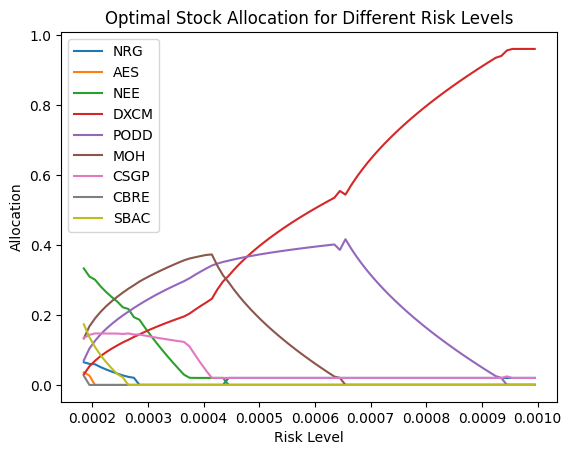

In [ ]:
# Create a dataframe of the portfolio proportions at each risk limit
param_df.columns = ["NRG","AES","NEE","DXCM","PODD","MOH","CSGP","CBRE","SBAC"]
# Plot the portfolio
param_df.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Allocation')
plt.show()

We can see the plateau occur at a risk level of around 0.00095.

### 2.3.2 The Efficient Frontier

Using the efficient frontier plot, we can see the relationship between risk and reward.

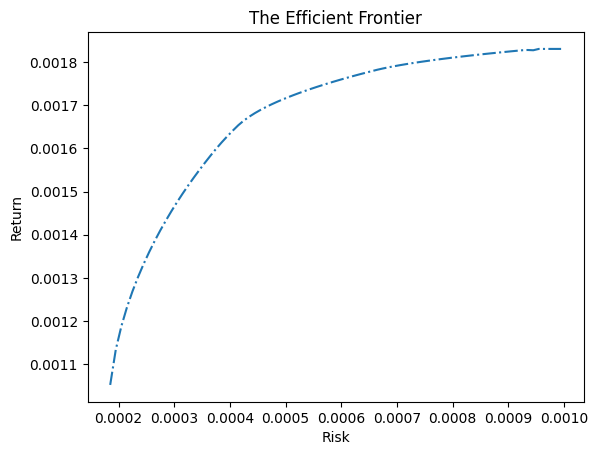

In [ ]:
# Plot return vs risk
plot(returns.keys(), returns.values(), '-.')
title('The Efficient Frontier')
xlabel('Risk')
ylabel('Return')
plt.show()

We can see that for the risk level we have chosen (0.000345), we will get a return of around 0.0015.

# 3 Investment Strategies

In this section, we evaluate a variety of balancing strategies for our portfolio in 2023 and compare to see which is most profitable.

We picked a portfolio allocation from the previous section with a decent mix of stock options and invested $100,000 into this allocation using four different strategies.


> Each subsection contains a detailed table showing the following performance metrics for the given strategy:
- The amount of money invested in each stock.
- Aggregate portfolio value.
- Percentual return of each stock.
- Percentual return of the entire portfolio.

In [ ]:
# Define the portfolio allocation
# 6.405278e-02	0.184192	0.281619	0.342576	0.127560
portfolio_allocation = {
    'NEE': 0.0640,
    'DXCM': 0.1842,
    'PODD': 0.2816,
    'MOH': 0.3426,
    'CSGP': 0.1276
}

# Define the initial investment budget ($100,000)
initial_budget = 100000

# Fetch stock data for 2023
stock_data_2023 = {}
for ticker in portfolio_allocation.keys():
    try:
        stock_data_2023[ticker] = si.get_data(ticker, start_date='2023-01-01', end_date='2023-12-31', interval='1d')['close']
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# Create a DataFrame for the 2023 data
df_stock_data_2023 = pd.DataFrame(stock_data_2023)
df_stock_data_2023 = df_stock_data_2023.ffill()
df_stock_data_2023 = df_stock_data_2023.bfill()

# Display the first few rows to confirm the data
print(df_stock_data_2023.head())

# Calculating the amount to invest in each stock
allocation_amount = {ticker: initial_budget * percentage for ticker, percentage in portfolio_allocation.items()}

# Calculating the number of stocks allocated for each
num_stocks_allocated = {ticker: allocation_amount / df_stock_data_2023[ticker]['2023-01-03'] for ticker, allocation_amount in allocation_amount.items()}

# Create DataFrame for the table
table_df = pd.DataFrame({
    'Stock': portfolio_allocation.keys(),
    'Number of Stocks Allocated': [num_stocks_allocated[ticker] for ticker in portfolio_allocation.keys()],
    'Amount Invested ($)': [allocation_amount[ticker] for ticker in portfolio_allocation.keys()]
})

# Print the DataFrame in a formatted table
print('\n\n\t\tStock Allocation')
print(table_df.to_string(index=False))

                  NEE        DXCM        PODD         MOH       CSGP
2023-01-03  83.830002  114.730003  286.380005  318.920013  77.650002
2023-01-04  84.489998  114.330002  279.720001  313.529999  78.000000
2023-01-05  82.629997  111.690002  286.160004  298.540009  74.900002
2023-01-06  83.650002  115.820000  292.309998  301.700012  77.120003
2023-01-09  84.070000  110.059998  296.269989  296.399994  77.080002


		Stock Allocation
Stock  Number of Stocks Allocated  Amount Invested ($)
  NEE                   76.344982               6400.0
 DXCM                  160.550854              18420.0
 PODD                   98.330887              28160.0
  MOH                  107.425055              34260.0
 CSGP                  164.327106              12760.0


## 3.1 Buy-and-Hold Strategy

In this strategy, we buy the stocks on the first trading day of the year, given our initial allocation, and sell them on the last trading day of the year.

### 3.1.1 Portfolio Returns

In [ ]:
# Calculate the initial investment per stock
investment_per_stock = {ticker: initial_budget * alloc for ticker, alloc in portfolio_allocation.items()}
initial_prices = df_stock_data_2023.iloc[0]
shares_purchased = {ticker: investment / initial_prices[ticker] for ticker, investment in investment_per_stock.items()}

# Calculate returns at the end of each month
df_monthly = df_stock_data_2023.resample('ME').last()  # Last trading day of each month

# Calculate portfolio value and returns for each month
monthly_results = []
for date, prices in df_monthly.iterrows():
    portfolio_value = sum([shares_purchased[ticker] * prices[ticker] for ticker in portfolio_allocation.keys()])
    if monthly_results:
        prev_portfolio_value = monthly_results[-1]['Portfolio Value']
        portfolio_return = portfolio_value - prev_portfolio_value  # Change in value (amount)
    else:
        portfolio_return = 0  # First month has no prior value to compare
    monthly_results.append({
        'Date': date,
        'Portfolio Value': portfolio_value,
        'Portfolio Return (Amount)': portfolio_return
    })

# Extract the start price for the first day of the first month
first_day_prices = df_stock_data_2023.iloc[0]  # First trading day of the year
first_day_date = df_stock_data_2023.index[0]

# Extract the last prices for the last trading day of each month
last_day_prices = df_stock_data_2023.resample('ME').last()

# Initialize the summary table
summary_table = []

# Add the first day of the year (initial investments)
first_day_stock_values = {ticker: shares_purchased[ticker] * initial_prices[ticker] for ticker in portfolio_allocation.keys()}
portfolio_value_start = sum([shares_purchased[ticker] * first_day_prices[ticker] for ticker in portfolio_allocation.keys()])
summary_table.append({
    'Date': df_stock_data_2023.index[0],
    'Portfolio Value': portfolio_value_start,
    **{f'{ticker} Value': first_day_stock_values[ticker] for ticker in portfolio_allocation.keys()}
})

# Add the last day of each subsequent month
for date, prices in df_monthly.iterrows():
    stock_values = {ticker: shares_purchased[ticker] * prices[ticker] for ticker in portfolio_allocation.keys()}
    portfolio_value_end = sum([shares_purchased[ticker] * prices[ticker] for ticker in portfolio_allocation.keys()])
    summary_table.append({
        'Date': date,
        'Portfolio Value': portfolio_value_end,
        **{f'{ticker} Value': stock_values[ticker] for ticker in portfolio_allocation.keys()},
    })

# Convert to DataFrame
summary_amt_table_df = pd.DataFrame(summary_table)

# Display the table
print('\t\t\tPortfolio Value and Aggregate Portfolio Value')
summary_amt_table_df

			Portfolio Value and Aggregate Portfolio Value


,Date,Portfolio Value,NEE Value,DXCM Value,PODD Value,MOH Value,CSGP Value
0,2023-01-03,100000.000000,6400.000000,18420.000000,28160.000000,34260.000000,12760.000000
1,2023-01-31,97442.882689,5697.625814,17193.390350,28252.431274,33498.353475,12801.081776
2,2023-02-28,91608.950059,5422.783994,17822.750628,27174.722588,29577.338965,11611.353883
3,2023-03-31,95950.136504,5884.671370,18652.798248,31363.618990,28735.126927,11313.920969
4,2023-04-30,101250.533546,5850.315778,19481.240017,31273.156254,32000.851223,12644.970274
5,2023-05-31,93873.036003,5608.302325,18826.193464,26967.245856,29423.721923,13047.572435
6,2023-06-30,101635.749425,5664.797448,20632.389345,28352.727699,32360.722535,14625.112398
7,2023-07-31,99315.775689,5596.087430,19998.213962,27213.073075,32709.853964,13798.547257
8,2023-08-31,86951.122465,5099.845046,16212.425760,18851.015074,33314.657549,13473.179036
9,2023-09-30,82894.706943,4373.804102,14979.395153,15682.793764,35223.602875,12635.111049


### 3.1.2 Percentual Returns for the Portfolio

In [ ]:
# Calculate the initial investment per stock
investment_per_stock = {ticker: initial_budget * alloc for ticker, alloc in portfolio_allocation.items()}
initial_prices = df_stock_data_2023.iloc[0]
shares_purchased = {ticker: investment / initial_prices[ticker] for ticker, investment in investment_per_stock.items()}

# Calculate returns at the end of each month
df_monthly = df_stock_data_2023.resample('ME').last()  # Last trading day of each month
monthly_returns = pd.DataFrame(index=df_monthly.index, columns=['Portfolio Value', 'Portfolio % Change'])

# Calculate portfolio value and returns for each month
monthly_results = []
for date, prices in df_monthly.iterrows():
    portfolio_value = sum([shares_purchased[ticker] * prices[ticker] for ticker in portfolio_allocation.keys()])
    if monthly_results:
        prev_portfolio_value = monthly_results[-1]['Portfolio Value']
        portfolio_return = (portfolio_value - prev_portfolio_value) / prev_portfolio_value * 100
    else:
        portfolio_return = 0  # First month has no prior value to compare
    monthly_results.append({
        'Date': date,
        'Portfolio Value': portfolio_value,
        'Portfolio % Change': portfolio_return
    })

# Extract the start price for the first day of the first month
first_day_prices = df_stock_data_2023.iloc[0]  # First trading day of the year
first_day_date = df_stock_data_2023.index[0]

# Extract the last prices for the last trading day of each month
last_day_prices = df_stock_data_2023.resample('ME').last()

# Initialize the summary table
summary_table = []

# Add the first day of the first month
portfolio_value_start = sum([shares_purchased[ticker] * first_day_prices[ticker] for ticker in portfolio_allocation.keys()])
summary_table.append({
    'Date': first_day_date,
    'Portfolio Value': portfolio_value_start,
    'Portfolio % Change': 0,  # No return for the first day
    **{f'{ticker} Return (%)': 0 for ticker in portfolio_allocation.keys()}
})

# Add the last day of each subsequent month
for date, prices in last_day_prices.iterrows():
    portfolio_value_end = sum([shares_purchased[ticker] * prices[ticker] for ticker in portfolio_allocation.keys()])
    if len(summary_table) == 1:  # First entry comparison
        portfolio_return = (portfolio_value_end - portfolio_value_start) / portfolio_value_start * 100
    else:
        prev_portfolio_value = summary_table[-1]['Portfolio Value']
        portfolio_return = (portfolio_value_end - prev_portfolio_value) / prev_portfolio_value * 100

    # Calculate individual stock returns
    stock_returns = (prices - first_day_prices) / first_day_prices * 100 if len(summary_table) == 1 else \
                    (prices - last_day_prices.iloc[len(summary_table) - 2]) / last_day_prices.iloc[len(summary_table) - 2] * 100

    summary_table.append({
        'Date': date,
        'Portfolio Value': portfolio_value_end,
        'Portfolio % Change': portfolio_return,
        **{f'{ticker} Return (%)': stock_returns[ticker] for ticker in portfolio_allocation.keys()}
    })

# Convert to DataFrame
summary_perc_table_df = pd.DataFrame(summary_table)

print('\t\t\t\tMonthly Returns for Buy and Hold Strategy')
summary_perc_table_df.head(20)

				Monthly Returns for Buy and Hold Strategy


,Date,Portfolio Value,Portfolio % Change,NEE Return (%),DXCM Return (%),PODD Return (%),MOH Return (%),CSGP Return (%)
0,2023-01-03,100000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-01-31,97442.882689,-2.557117,-10.974597,-6.659119,0.328236,-2.223136,0.321957
2,2023-02-28,91608.950059,-5.987028,-4.823796,3.660478,-3.814570,-11.705096,-9.293964
3,2023-03-31,95950.136504,4.738823,8.517532,4.657236,15.414680,-2.847491,-2.561570
4,2023-04-30,101250.533546,5.524116,-0.583815,4.441381,-0.288432,11.364920,11.764704
5,2023-05-31,93873.036003,-7.286379,-4.136759,-3.362448,-13.768711,-8.053315,3.183892
6,2023-06-30,101635.749425,8.269375,1.007348,9.594058,5.137647,9.981744,12.090678
7,2023-07-31,99315.775689,-2.282636,-1.212930,-3.073689,-4.019559,1.078874,-5.651684
8,2023-08-31,86951.122465,-12.449838,-8.867667,-18.930632,-30.728092,1.848995,-2.357989
9,2023-09-30,82894.706943,-4.665168,-14.236529,-7.605466,-16.806635,5.730046,-6.220269


## 3.2 Daily Rebalancing Strategy

In this strategy, we sell the stocks at the end of each **day** and re-buy them using the original allocation.

### 3.2.1 Portfolio Returns

In [ ]:
# Initialize variables for daily dollar values based on rebalancing
daily_results_amount = []

# Use the daily stock prices directly
df_daily = df_stock_data_2023

# Add initial portfolio and stock values
initial_prices = df_stock_data_2023.iloc[0]
initial_portfolio_value = initial_budget
initial_stock_values = {ticker: (initial_portfolio_value * allocation) for ticker, allocation in portfolio_allocation.items()}

# Recalculate the number of shares dynamically after each rebalancing
shares_purchased = {ticker: (initial_portfolio_value * allocation) / initial_prices[ticker] for ticker, allocation in portfolio_allocation.items()}

# Iterate over daily results for dollar value changes
for date, prices in df_daily.iterrows():
    # Step 1: Calculate the total portfolio value at the end of the day
    portfolio_value = sum([shares_purchased[ticker] * prices[ticker] for ticker in portfolio_allocation.keys()])

    # Step 2: Calculate the dollar amount for each stock based on the portfolio value
    stock_values = {ticker: shares_purchased[ticker] * prices[ticker] for ticker in portfolio_allocation.keys()}

    # Step 3: Rebalance the portfolio (update shares purchased based on MPT allocation)
    shares_purchased = {ticker: (portfolio_value * allocation) / prices[ticker] for ticker, allocation in portfolio_allocation.items()}

    # Append dollar values
    daily_results_amount.append({
        'Date': date,
        'Portfolio Value': portfolio_value,
        **{f'{ticker} Value': stock_values[ticker] for ticker in portfolio_allocation.keys()}
    })

# Convert results to DataFrame
df_daily_amount = pd.DataFrame(daily_results_amount)

# Display the table
print("\t\t\tDaily Dollar Values (Rebalanced)")
df_daily_amount

			Daily Dollar Values (Rebalanced)


,Date,Portfolio Value,NEE Value,DXCM Value,PODD Value,MOH Value,CSGP Value
0,2023-01-03,100000.000000,6400.000000,18420.000000,28160.000000,34260.000000,12760.000000
1,2023-01-04,98809.774345,6450.387385,18355.779413,27505.115930,33680.977380,12817.514236
2,2023-01-05,96771.316107,6184.610033,17780.485829,28465.444454,32233.740573,12107.035218
3,2023-01-06,98809.477170,6269.816587,18484.407424,27836.461924,33504.781730,12714.009505
4,2023-01-09,97711.786607,6355.557730,17295.541613,28201.697108,33257.440485,12601.549672
...,...,...,...,...,...,...,...
245,2023-12-22,99817.811030,6427.830156,18358.981046,27851.993510,34336.966213,12842.040105
246,2023-12-26,100612.314709,6437.522006,18594.129901,28697.708399,34137.465302,12745.489101
247,2023-12-27,100688.715789,6478.758268,18559.788835,28423.569053,34381.134269,12845.465365
248,2023-12-28,100568.592742,6490.881794,18611.317570,28099.112172,34456.320548,12910.960658


### 3.2.2 Percentual Returns for the Portfolio

In [ ]:
# Initialize variables for daily percentage changes
daily_results_percentage = []

# Use the daily stock prices directly
df_daily = df_stock_data_2023

# Add initial portfolio and stock values (percentage changes are 0 for the first row)
initial_prices = df_stock_data_2023.iloc[0]

# Recalculate the number of shares dynamically after each rebalancing
shares_purchased = {ticker: (initial_portfolio_value * allocation) / initial_prices[ticker] for ticker, allocation in portfolio_allocation.items()}

# Iterate over daily results for percentage changes
for i, (date, prices) in enumerate(df_daily.iterrows()):
    # Step 1: Calculate the total portfolio value at the end of the day
    portfolio_value = sum([shares_purchased[ticker] * prices[ticker] for ticker in portfolio_allocation.keys()])

    # Step 2: Calculate percentage changes
    if i == 0:
        # First percentage change row: compare with initial values
        percentage_changes = {
            f'{ticker} % Change': ((prices[ticker] - initial_prices[ticker]) / initial_prices[ticker]) * 100
            for ticker in portfolio_allocation.keys()
        }
        prev_portfolio_value = initial_portfolio_value
        portfolio_percentage_change = ((portfolio_value - prev_portfolio_value) / prev_portfolio_value) * 100
    else:
        # Subsequent rows: compare with the previous day's prices
        prev_prices = df_daily.iloc[i - 1]
        percentage_changes = {
            f'{ticker} % Change': ((prices[ticker] - prev_prices[ticker]) / prev_prices[ticker]) * 100
            for ticker in portfolio_allocation.keys()
        }
        prev_portfolio_value = sum([shares_purchased[ticker] * prev_prices[ticker] for ticker in portfolio_allocation.keys()])
        portfolio_percentage_change = ((portfolio_value - prev_portfolio_value) / prev_portfolio_value) * 100

    # Step 3: Rebalance the portfolio (update shares purchased based on MPT allocation)
    shares_purchased = {ticker: (portfolio_value * allocation) / prices[ticker] for ticker, allocation in portfolio_allocation.items()}

    # Append percentage changes and portfolio value
    daily_results_percentage.append({
        'Date': date,
        'Portfolio Value': portfolio_value,
        'Portfolio % Change': portfolio_percentage_change,
        **percentage_changes
    })

# Convert results to DataFrame
df_daily_percentage = pd.DataFrame(daily_results_percentage)

# Display the table
print("\t\t\tDaily Percentage Changes (Rebalanced)")
df_daily_percentage

			Daily Percentage Changes (Rebalanced)


,Date,Portfolio Value,Portfolio % Change,NEE % Change,DXCM % Change,PODD % Change,MOH % Change,CSGP % Change
0,2023-01-03,100000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-01-04,98809.774345,-1.190226,0.787303,-0.348646,-2.325583,-1.690084,0.450739
2,2023-01-05,96771.316107,-2.063013,-2.201445,-2.309105,2.302303,-4.781039,-3.974357
3,2023-01-06,98809.477170,2.106162,1.234424,3.697732,2.149145,1.058486,2.963954
4,2023-01-09,97711.786607,-1.110916,0.502090,-4.973236,1.354723,-1.756718,-0.051868
...,...,...,...,...,...,...,...,...
245,2023-12-22,99817.811030,-0.364229,0.251680,-0.513033,-1.274151,0.041871,0.459402
246,2023-12-26,100612.314709,0.795954,0.769873,1.129578,2.095483,-0.175792,0.068592
247,2023-12-27,100688.715789,0.075936,0.614520,0.145690,0.321685,-0.257167,0.057127
248,2023-12-28,100568.592742,-0.119301,0.726310,0.347531,-0.898747,-0.114893,0.490980


## 3.3 Weekly Rebalancing Strategy

In this strategy, we sell the stocks at the end of each **week** and re-buy them using the original allocation.

### 3.3.1 Portfolio Returns

In [ ]:
# Initialize variables for weekly amount changes based on percentage changes
weekly_results_amount = []

# Resample stock prices to weekly frequency (end of each week)
df_weekly = df_stock_data_2023.resample('W').last()

# Add initial portfolio and stock values (amount changes are 0 for the first row)
initial_prices = df_stock_data_2023.iloc[0]
initial_portfolio_value = initial_budget
initial_stock_values = {ticker: (initial_portfolio_value * allocation) for ticker, allocation in portfolio_allocation.items()}
weekly_results_amount.append({
    'Date': df_stock_data_2023.index[0],
    'Portfolio Value': initial_portfolio_value,
    **{f'{ticker} Value': initial_stock_values[ticker] for ticker in portfolio_allocation.keys()}
})

# Recalculate the number of shares dynamically after each rebalancing
shares_purchased = {ticker: (initial_portfolio_value * allocation) / initial_prices[ticker] for ticker, allocation in portfolio_allocation.items()}

# Iterate over weekly results for amount changes
for i, (date, prices) in enumerate(df_weekly.iterrows()):
    # Step 1: Calculate the total portfolio value at the end of the week
    portfolio_value = sum([shares_purchased[ticker] * prices[ticker] for ticker in portfolio_allocation.keys()])

    # Step 2: Calculate the dollar amount for each stock based on the portfolio value
    stock_values = {ticker: shares_purchased[ticker] * prices[ticker] for ticker in portfolio_allocation.keys()}

    # Step 3: Rebalance the portfolio (update shares purchased based on MPT allocation)
    shares_purchased = {ticker: (portfolio_value * allocation) / prices[ticker] for ticker, allocation in portfolio_allocation.items()}

    # Append dollar amounts
    weekly_results_amount.append({
        'Date': date,
        'Portfolio Value': portfolio_value,
        **{f'{ticker} Value': stock_values[ticker] for ticker in portfolio_allocation.keys()}
    })

# Convert results to DataFrame
df_weekly_amount = pd.DataFrame(weekly_results_amount)

# Display the table
print("\t\t\tWeekly Dollar Amounts (Rebalanced)")
df_weekly_amount

			Weekly Dollar Amounts (Rebalanced)


,Date,Portfolio Value,NEE Value,DXCM Value,PODD Value,MOH Value,CSGP Value
0,2023-01-03,100000.000000,6400.000000,18420.000000,28160.000000,34260.000000,12760.000000
1,2023-01-08,98807.406420,6386.257880,18594.999843,28743.101442,32410.140421,12672.906835
2,2023-01-15,99502.706851,6401.538642,17045.322053,29116.809239,33688.722821,13250.314097
3,2023-01-22,97409.576633,6153.093181,18225.325548,26959.216144,33771.723819,12300.217942
4,2023-01-29,96138.323369,5758.760994,17753.201599,26609.419713,33704.618358,12312.322705
5,2023-02-05,97149.949184,6078.770685,17992.429397,27991.406830,33009.352468,12077.989804
6,2023-02-12,98941.489033,6223.425459,19456.275628,27324.060375,33641.756559,12295.971011
7,2023-02-19,98028.931090,6444.938084,17741.145191,27972.491523,32979.494495,12890.861797
8,2023-02-26,94782.987462,6014.056110,17322.126370,27451.068637,32588.752318,11406.984028
9,2023-03-05,95773.409949,6141.813111,19493.719239,26039.826299,31716.474431,12381.576869


### 3.3.2 Percentual Returns for the Portfolio

In [ ]:
# Initialize variables for weekly percentage changes
weekly_results_percentage = []

# Resample stock prices to weekly frequency (end of each week)
df_weekly = df_stock_data_2023.resample('W').last()

# Add initial portfolio and stock values (percentage changes are 0 for the first row)
initial_prices = df_stock_data_2023.iloc[0]
initial_portfolio_value = initial_budget
weekly_results_percentage.append({
    'Date': df_stock_data_2023.index[0],
    'Portfolio Value': initial_portfolio_value,
    'Portfolio % Change': 0,
    **{f'{ticker} % Change': 0 for ticker in portfolio_allocation.keys()}
})

# Recalculate the number of shares dynamically after each rebalancing
shares_purchased = {ticker: (initial_portfolio_value * allocation) / initial_prices[ticker] for ticker, allocation in portfolio_allocation.items()}

# Iterate over weekly results for percentage changes
for i, (date, prices) in enumerate(df_weekly.iterrows()):
    # Step 1: Calculate the total portfolio value at the end of the week
    portfolio_value = sum([shares_purchased[ticker] * prices[ticker] for ticker in portfolio_allocation.keys()])

    # Step 2: Calculate percentage changes
    if i == 0:
        # First percentage change row: compare with initial values
        percentage_changes = {
            f'{ticker} % Change': ((prices[ticker] - initial_prices[ticker]) / initial_prices[ticker]) * 100
            for ticker in portfolio_allocation.keys()
        }
        prev_portfolio_value = initial_portfolio_value
        portfolio_percentage_change = ((portfolio_value - prev_portfolio_value) / prev_portfolio_value) * 100
    else:
        # Subsequent rows: compare with the previous week's prices
        prev_prices = df_weekly.iloc[i - 1]
        percentage_changes = {
            f'{ticker} % Change': ((prices[ticker] - prev_prices[ticker]) / prev_prices[ticker]) * 100
            for ticker in portfolio_allocation.keys()
        }
        prev_portfolio_value = sum([shares_purchased[ticker] * prev_prices[ticker] for ticker in portfolio_allocation.keys()])
        portfolio_percentage_change = ((portfolio_value - prev_portfolio_value) / prev_portfolio_value) * 100

    # Step 3: Rebalance the portfolio (update shares purchased based on MPT allocation)
    shares_purchased = {ticker: (portfolio_value * allocation) / prices[ticker] for ticker, allocation in portfolio_allocation.items()}

    # Append percentage changes and portfolio value
    weekly_results_percentage.append({
        'Date': date,
        'Portfolio Value': portfolio_value,
        'Portfolio % Change': portfolio_percentage_change,
        **percentage_changes
    })

# Convert results to DataFrame
df_weekly_percentage = pd.DataFrame(weekly_results_percentage)

# Display the table
print("\t\t\tWeekly Percentage Changes (Rebalanced)")
df_weekly_percentage

			Weekly Percentage Changes (Rebalanced)


,Date,Portfolio Value,Portfolio % Change,NEE % Change,DXCM % Change,PODD % Change,MOH % Change,CSGP % Change
0,2023-01-03,100000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-01-08,98807.406420,-1.192594,-0.214721,0.950053,2.070673,-5.399473,-0.682548
2,2023-01-15,99502.706851,0.703693,1.231319,-6.346053,4.645759,-0.480614,5.095955
3,2023-01-22,97409.576633,-2.103591,-3.377422,-0.562368,-3.785680,-0.932552,-3.121538
4,2023-01-29,96138.323369,-1.305060,-7.626495,-1.056925,-2.993441,0.995122,-0.942432
5,2023-02-05,97149.949184,1.052261,-1.204027,1.602323,3.394046,0.219701,-1.542809
6,2023-02-12,98941.489033,1.844098,0.093745,8.724522,-0.121961,1.076158,-0.809614
7,2023-02-19,98028.931090,-0.922321,1.779505,-2.655015,0.396843,-2.707762,2.106370
8,2023-02-26,94782.987462,-3.311210,-4.140925,-4.069367,-0.557430,-2.965514,-8.806078
9,2023-03-05,95773.409949,1.044937,1.247948,11.654103,-2.439270,-2.328658,2.375230


## 3.4 Monthly Rebalancing Strategy

In this strategy, we sell the stocks at the end of each **month** and re-buy them using the original allocation.


### 3.4.1 Portfolio Returns

In [ ]:
# Initialize variables for monthly amount changes based on percentage changes
monthly_results_amount = []

# Resample stock prices to monthly frequency (end of each month)
df_monthly = df_stock_data_2023.resample('ME').last()

# Add initial portfolio and stock values (amount changes are 0 for the first row)
initial_prices = df_stock_data_2023.iloc[0]
initial_portfolio_value = initial_budget
initial_stock_values = {ticker: (initial_portfolio_value * allocation) for ticker, allocation in portfolio_allocation.items()}
monthly_results_amount.append({
    'Date': df_stock_data_2023.index[0],
    'Portfolio Value': initial_portfolio_value,
    **{f'{ticker} Value': initial_stock_values[ticker] for ticker in portfolio_allocation.keys()}
})

# Recalculate the number of shares dynamically after each rebalancing
shares_purchased = {ticker: (initial_portfolio_value * allocation) / initial_prices[ticker] for ticker, allocation in portfolio_allocation.items()}

# Iterate over monthly results for amount changes
for i, (date, prices) in enumerate(df_monthly.iterrows()):
    # Step 1: Calculate the total portfolio value at the end of the month
    portfolio_value = sum([shares_purchased[ticker] * prices[ticker] for ticker in portfolio_allocation.keys()])

    # Step 2: Calculate the dollar amount for each stock based on the portfolio value
    stock_values = {ticker: shares_purchased[ticker] * prices[ticker] for ticker in portfolio_allocation.keys()}

    # Step 3: Rebalance the portfolio (update shares purchased based on MPT allocation)
    shares_purchased = {ticker: (portfolio_value * allocation) / prices[ticker] for ticker, allocation in portfolio_allocation.items()}

    # Append dollar amounts
    monthly_results_amount.append({
        'Date': date,
        'Portfolio Value': portfolio_value,
        **{f'{ticker} Value': stock_values[ticker] for ticker in portfolio_allocation.keys()}
    })

# Convert results to DataFrame
df_monthly_amount = pd.DataFrame(monthly_results_amount)

# Display the table
print("\t\t\tMonthly Dollar Amounts (Rebalanced)")
df_monthly_amount

			Monthly Dollar Amounts (Rebalanced)


,Date,Portfolio Value,NEE Value,DXCM Value,PODD Value,MOH Value,CSGP Value
0,2023-01-03,100000.000000,6400.000000,18420.000000,28160.000000,34260.000000,12760.000000
1,2023-01-31,97442.882689,5697.625814,17193.390350,28252.431274,33498.353475,12801.081776
2,2023-02-28,91689.151917,5935.515985,18605.997426,26393.201050,29476.310289,11278.127167
3,2023-03-31,95761.389979,6367.923520,17675.709033,29799.683824,30518.229572,11399.844030
4,2023-04-30,101597.389418,6092.948522,18422.674180,26888.627651,36536.438488,13656.700577
5,2023-05-31,94369.562697,6233.251229,18084.982584,24670.620856,32004.126928,13376.581100
6,2023-06-30,102146.532949,6100.492329,19050.596373,27939.771203,35558.211064,13497.461980
7,2023-07-31,99973.629615,6458.084300,18237.064845,27608.259083,35372.958492,12297.262896
8,2023-08-31,87601.895690,5830.931283,14929.039784,19501.825365,34884.264167,12455.835091
9,2023-09-30,82454.928922,4808.347262,14909.030642,20522.716478,31732.134443,10482.700096


### 3.4.2 Percentual Returns for the Portfolio

In [ ]:
# Initialize variables for monthly percentage changes
monthly_results_percentage = []

# Resample stock prices to monthly frequency (end of each month)
df_monthly = df_stock_data_2023.resample('ME').last()

# Add initial portfolio and stock values (percentage changes are 0 for the first row)
initial_prices = df_stock_data_2023.iloc[0]
initial_portfolio_value = initial_budget
monthly_results_percentage.append({
    'Date': df_stock_data_2023.index[0],
    'Portfolio Value': initial_portfolio_value,
    'Portfolio % Change': 0,
    **{f'{ticker} % Change': 0 for ticker in portfolio_allocation.keys()}
})

# Recalculate the number of shares dynamically after each rebalancing
shares_purchased = {ticker: (initial_portfolio_value * allocation) / initial_prices[ticker] for ticker, allocation in portfolio_allocation.items()}

# Iterate over monthly results for percentage changes
for i, (date, prices) in enumerate(df_monthly.iterrows()):
    # Step 1: Calculate the total portfolio value at the end of the month
    portfolio_value = sum([shares_purchased[ticker] * prices[ticker] for ticker in portfolio_allocation.keys()])

    # Step 2: Calculate percentage changes for each stock
    if i == 0:
        # First percentage change row: compare with initial values
        percentage_changes = {
            f'{ticker} % Change': ((prices[ticker] - initial_prices[ticker]) / initial_prices[ticker]) * 100
            for ticker in portfolio_allocation.keys()
        }
        prev_portfolio_value = initial_portfolio_value
        portfolio_percentage_change = ((portfolio_value - prev_portfolio_value) / prev_portfolio_value) * 100
    else:
        # Subsequent rows: compare with the previous month's prices
        prev_prices = df_monthly.iloc[i - 1]
        percentage_changes = {
            f'{ticker} % Change': ((prices[ticker] - prev_prices[ticker]) / prev_prices[ticker]) * 100
            for ticker in portfolio_allocation.keys()
        }
        prev_portfolio_value = sum([shares_purchased[ticker] * prev_prices[ticker] for ticker in portfolio_allocation.keys()])
        portfolio_percentage_change = ((portfolio_value - prev_portfolio_value) / prev_portfolio_value) * 100

    # Step 3: Rebalance the portfolio (update shares purchased based on MPT allocation)
    shares_purchased = {ticker: (portfolio_value * allocation) / prices[ticker] for ticker, allocation in portfolio_allocation.items()}

    # Append percentage changes and portfolio value
    monthly_results_percentage.append({
        'Date': date,
        'Portfolio Value': portfolio_value,
        'Portfolio % Change': portfolio_percentage_change,
        **percentage_changes
    })

# Convert results to DataFrame
df_monthly_percentage = pd.DataFrame(monthly_results_percentage)

# Display the table
print("\t\t\tMonthly Percentage Changes (Rebalanced)")
df_monthly_percentage

			Monthly Percentage Changes (Rebalanced)


,Date,Portfolio Value,Portfolio % Change,NEE % Change,DXCM % Change,PODD % Change,MOH % Change,CSGP % Change
0,2023-01-03,100000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-01-31,97442.882689,-2.557117,-10.974597,-6.659119,0.328236,-2.223136,0.321957
2,2023-02-28,91689.151917,-5.904721,-4.823796,3.660478,-3.814570,-11.705096,-9.293964
3,2023-03-31,95761.389979,4.441352,8.517532,4.657236,15.414680,-2.847491,-2.561570
4,2023-04-30,101597.389418,6.094314,-0.583815,4.441381,-0.288432,11.364920,11.764704
5,2023-05-31,94369.562697,-7.114185,-4.136759,-3.362448,-13.768711,-8.053315,3.183892
6,2023-06-30,102146.532949,8.240973,1.007348,9.594058,5.137647,9.981744,12.090678
7,2023-07-31,99973.629615,-2.127241,-1.212930,-3.073689,-4.019559,1.078874,-5.651684
8,2023-08-31,87601.895690,-12.374997,-8.867667,-18.930632,-30.728092,1.848995,-2.357989
9,2023-09-30,82454.928922,-5.875406,-14.236529,-7.605466,-16.806635,5.730046,-6.220269


## 3.5 Plots

Now that we have results for each case, we can compare them to see which method is best.

### 3.5.1 Strategy Comparison

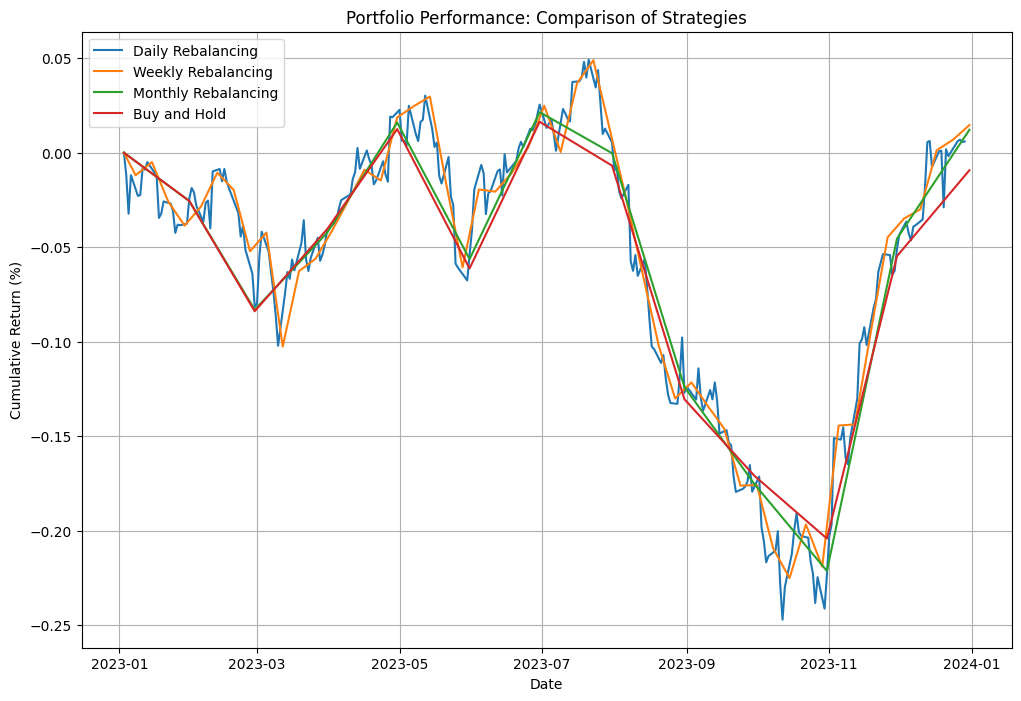

In [ ]:
# Helper function to calculate cumulative returns
def calculate_cumulative_returns(df):
    df['Cumulative Return (%)'] = (1 + df['Portfolio % Change'] / 100).cumprod() - 1
    return df

# Calculate cumulative returns for each strategy
df_daily_percentage = calculate_cumulative_returns(df_daily_percentage)
df_weekly_percentage = calculate_cumulative_returns(df_weekly_percentage)
df_monthly_percentage = calculate_cumulative_returns(df_monthly_percentage)
summary_perc_table_df = calculate_cumulative_returns(summary_perc_table_df)

# Plot performance
plt.figure(figsize=(12, 8))

# Add the performance of each strategy
plt.plot(df_daily_percentage['Date'], df_daily_percentage['Cumulative Return (%)'], label='Daily Rebalancing')
plt.plot(df_weekly_percentage['Date'], df_weekly_percentage['Cumulative Return (%)'], label='Weekly Rebalancing')
plt.plot(df_monthly_percentage['Date'], df_monthly_percentage['Cumulative Return (%)'], label='Monthly Rebalancing')
plt.plot(summary_perc_table_df['Date'], summary_perc_table_df['Cumulative Return (%)'], label='Buy and Hold')

# Add labels, title, and legend
plt.title('Portfolio Performance: Comparison of Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid()

# Show the plot
plt.show()

Looking at the plot, we can see that the weekly rebalancing strategy yeilds the highest profit amongst all the strategies we explored.

We can also see that the monthly rebalancing strategy is the runner up in highest overall profit.

All 3 rebalancing strategies are very close to each other while the buy-and-hold strategy showed the least profit at the end of the year.

# 4 Monte Carlo Analysis

In this section, we run a simulation on the portfolio to evaluate the quality and determine the probability of losing money using this allocation.

We sample the daily returns for each stock 252 times and repeat this process 1000 times to simulate the annual performance of the model.

We assume the daily return of each stock follows a normal distribution and present a density plot showing the expected return of the portfolio.

## 4.1 Monte Carlo Simulation

In [ ]:
np.random.seed(42)  # Set seed for reproducibility
num_simulations = 1000  # Number of simulations
time_horizon = 252      # Trading days in one year

# Calculate historical mean and standard deviation for each stock (based on historical data)
means_old = return_data.mean()
std_devs_old = return_data.std()
# Initialize array to store final portfolio values at the end of each simulation
final_portfolio_values = []

for sim in range(num_simulations):
    simulated_returns = []
    selected_columns = ['NEE', 'DXCM', 'PODD', 'MOH', 'CSGP']
    for stock in selected_columns:
        daily_simulated = np.random.normal(means_old[stock], std_devs_old[stock], time_horizon)
        simulated_returns.append(daily_simulated)

    # Convert to DataFrame for calculation
    simulated_returns_df = pd.DataFrame(simulated_returns).T
    simulated_returns_df.columns = selected_columns

    # Weighted portfolio daily returns
    portfolio_daily_return = (simulated_returns_df * list(portfolio_allocation.values())).sum(axis=1)
    portfolio_cumulative_return = np.cumprod(1 + portfolio_daily_return)

    final_portfolio_values.append(portfolio_cumulative_return.iloc[-1])

# Convert final values to numpy array for analysis
final_portfolio_values = np.array(final_portfolio_values)

We can preview some of our values after the simulation, such as the average expected value at the end of the simulation, the risk of the allocation, and the probability of losing money.

In [ ]:
# Metrics
expected_final_value = final_portfolio_values.mean()
risk = final_portfolio_values.std()
probability_of_loss = np.mean(final_portfolio_values < 1.0)

print("Expected Final Value of Portfolio:", expected_final_value)
print("Risk (Standard Deviation of Final Value):", risk)
print("Probability of Loss:", probability_of_loss)

Expected Final Value of Portfolio: 1.468051380945436
Risk (Standard Deviation of Final Value): 0.3136276450594107
Probability of Loss: 0.044


## 4.2 Plots

We can now plot the results to get a visual representation of our simulated portfolio.

### 4.2.1 Density Plot

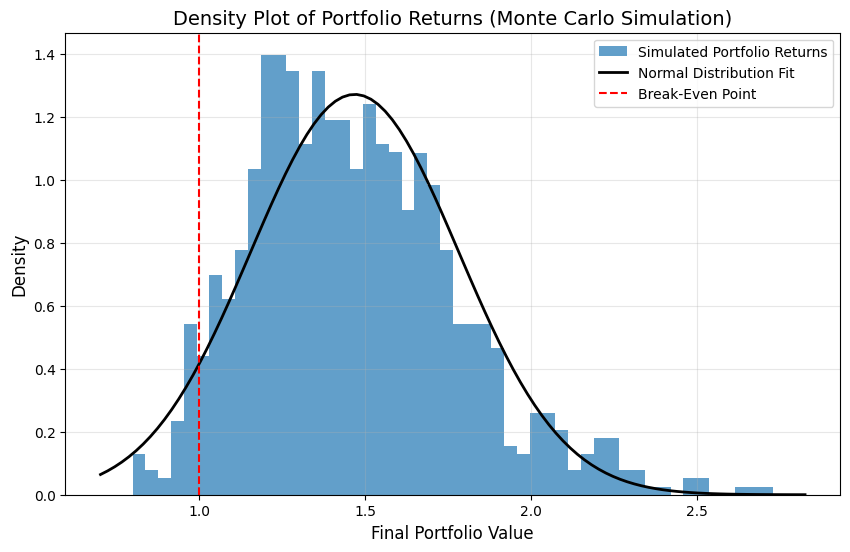


**Monte Carlo Simulation Results for MPT Portfolio (Buy-and-Hold Strategy, 2023):**
- **Expected Final Value of Portfolio:** 1.4681
- **Risk (Standard Deviation of Final Value):** 0.3136
- **Probability of Loss (Final Value < Initial Investment):** 4.40%



In [ ]:
# Plot density of portfolio returns
plt.figure(figsize=(10, 6))
plt.hist(final_portfolio_values, bins=50, density=True, alpha=0.7, label='Simulated Portfolio Returns')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Use norm.pdf from scipy.stats
p = scipy.stats.norm.pdf(x, expected_final_value, risk)

plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution Fit')
plt.axvline(x=1.0, color='red', linestyle='--', label='Break-Even Point')
plt.title('Density Plot of Portfolio Returns (Monte Carlo Simulation)', fontsize=14)
plt.xlabel('Final Portfolio Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

# Presenting results as a text block
results_text = f"""
**Monte Carlo Simulation Results for MPT Portfolio (Buy-and-Hold Strategy, 2023):**
- **Expected Final Value of Portfolio:** {expected_final_value:.4f}
- **Risk (Standard Deviation of Final Value):** {risk:.4f}
- **Probability of Loss (Final Value < Initial Investment):** {probability_of_loss:.2%}
"""
print(results_text)

# Conclusion

In this project, we learned some interesting things about the model and stock market.

- 3 out of the 5 stocks are in the optimal allocation chosen are from the Health Care Sector, which shows how volatile the other sectors are in comparison.

- Because of the diversification such as MOH (highest allocation) and NEE (lowest allocation), we are able to reduce the risk significantly at the same time, we reduce the probability of the loss.

- As seen in Section 2.3.1, we can see that the stocks in the Utility sector (NRG, or AES), they are getting flat in earlier risk levels, suggesting, the Utility sector stocks have lower risk reducing the volatility in the portfolio, but at the same time, it has limited return potential.

- We also learned that the probability of losing money is quite low with the rebalancing investment strategies in Sections 3.2 through 3.4.

- The weekly rebalancing strategy turned out to be the best strategy to invest based on the high yield in portfolio, however, the profit was not significant as compared to monthly rebalancing with only $250 of difference.

- This suggests any rebalancing strategy will lead to profitable scenario but the best approach might change according to the future market scenario.

- As the density plot shows in Monte Carlo simulation, the plot is normally distributed with a long right tail.

### Contribution

Rohit Akole
* Aggregated Hours: 10 hours
* Worked on coding part 1, 2, 3, and 4.
* Created a few markdown cells.

Dimitri Alston
* Aggregated Hours: 7 hours
* Validated and updated optimization formulation and results.
* Worked on markdown cells and added equations.
* Recorded video.

Pranjal Jain
* Aggregated Hours: 10 hours
* Worked on coding part 2 and 4.
* Cleaned code for some parts.

Sumit Pal
* Aggregated Hours: 10 hours
* Worked on coding part 1 and 3.
* Helped with comments and conclusion part.

Nishitha Santhakumar
* Aggregated hours: 2 Hours
* Assisted with part 3.